In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img

2022-12-12 07:34:54.120725: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


First, we will load the training dataframe and split it into train and validation

In [2]:
df_train_full = pd.read_csv('../data/train.csv', dtype={'Id': str})
df_train_full['filename'] = '../data/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,data/images/0560.jpg
1,4675,cup,data/images/4675.jpg
2,0875,glass,data/images/0875.jpg
3,4436,spoon,data/images/4436.jpg
4,8265,plate,data/images/8265.jpg


In [3]:
df_train_full.shape

(5559, 3)

In [4]:
val_cutoff = int(len(df_train_full) * 0.8)
df_train = df_train_full[:val_cutoff]
df_val = df_train_full[val_cutoff:]

Now let's create image generators

In [5]:
image_size = (299, 299)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=32,
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=32,
)

Found 4447 validated image filenames belonging to 6 classes.
Found 1112 validated image filenames belonging to 6 classes.


Model building and training the model

In [6]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):
    
    # creating base model by creating a Xception network and removing the dense layers.
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(6)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [7]:
input_size = 299
learning_rate = 0.001
size = 100
droprate = 0.2

checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [8]:
model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)

history = model.fit(train_generator, epochs=30, validation_data=val_generator,
                   callbacks=[checkpoint, early_stop])

2022-12-12 07:34:59.298974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 07:34:59.305880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 07:34:59.306511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 07:34:59.307560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/30


2022-12-12 07:35:05.755114: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-12 07:35:06.418441: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-12 07:35:06.419379: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-12 07:35:06.419420: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-12 07:35:06.420386: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-12 07:35:06.420483: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


139/139 [==============================] - 86s 583ms/step - loss: 0.2781 - accuracy: 0.9103 - val_loss: 0.1355 - val_accuracy: 0.9550
Epoch 2/30
139/139 [==============================] - 72s 514ms/step - loss: 0.1229 - accuracy: 0.9606 - val_loss: 0.1150 - val_accuracy: 0.9595
Epoch 3/30
139/139 [==============================] - 72s 514ms/step - loss: 0.0927 - accuracy: 0.9721 - val_loss: 0.1254 - val_accuracy: 0.9514
Epoch 4/30
139/139 [==============================] - 72s 515ms/step - loss: 0.0800 - accuracy: 0.9784 - val_loss: 0.1198 - val_accuracy: 0.9586
Epoch 5/30
139/139 [==============================] - 71s 507ms/step - loss: 0.0674 - accuracy: 0.9789 - val_loss: 0.1222 - val_accuracy: 0.9559
Epoch 6/30
139/139 [==============================] - 73s 521ms/step - loss: 0.0638 - accuracy: 0.9789 - val_loss: 0.1289 - val_accuracy: 0.9586
Epoch 7/30
139/139 [==============================] - 70s 504ms/step - loss: 0.0485 - accuracy: 0.9856 - val_loss: 0.1512 - val_accuracy: 0.9

Now let's use this model to predict the labels for test data

In [9]:
df_test = pd.read_csv('../data/test.csv', dtype={'Id': str})
df_test['filename'] = '../data/images/' + df_test['Id'] + '.jpg'
df_test.head()

,Id,filename
0,0678,data/images/0678.jpg
1,3962,data/images/3962.jpg
2,9271,data/images/9271.jpg
3,5133,data/images/5133.jpg
4,8842,data/images/8842.jpg


In [10]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filename',
    class_mode='input',
    target_size=image_size,
    batch_size=32,
    shuffle=False
)

Found 3808 validated image filenames.


In [11]:
y_pred = model.predict(test_generator)

119/119 [==============================] - 58s 483ms/step


In [12]:
classes = np.array(list(train_generator.class_indices.keys()))
classes

array(['cup', 'fork', 'glass', 'knife', 'plate', 'spoon'], dtype='<U5')

In [13]:
predictions = classes[y_pred.argmax(axis=1)]

In [14]:
predictions[:20]

array(['spoon', 'knife', 'fork', 'plate', 'fork', 'spoon', 'spoon',
       'fork', 'knife', 'cup', 'plate', 'glass', 'knife', 'plate',
       'spoon', 'plate', 'spoon', 'cup', 'knife', 'cup'], dtype='<U5')

Finally, we need to prepare the submission

In [15]:
df_submission = pd.DataFrame()
df_submission['filename'] = test_generator.filenames
df_submission['label'] = predictions

df_submission['Id'] = df_submission.filename.str[len('../data/images/'):-4]
del df_submission['filename']

In [16]:
df_submission.head(20)

,label,Id
0,spoon,0678
1,knife,3962
2,fork,9271
3,plate,5133
4,fork,8842
5,spoon,8256
6,spoon,4622
7,fork,2775
8,knife,5900
9,cup,6372


In [17]:
df_submission[['Id', 'label']].to_csv('submission.csv', index=False)

In [18]:
# !kaggle competitions submit kitchenware-classification -f submission.csv -m 'validation: 0.9595'

In [19]:
df_test.iloc[0]["filename"]

'data/images/0678.jpg'

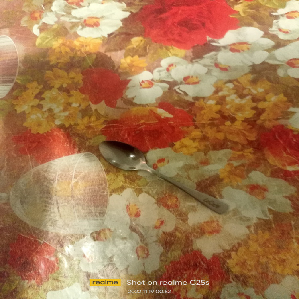

In [20]:
img = load_img(df_test.iloc[0]["filename"], target_size=(299, 299))
img

In [21]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)

1/1 [==============================] - 1s 886ms/step


In [22]:
X.shape

(1, 299, 299, 3)

In [23]:
prediction = classes[pred.argmax(axis=1)]
prediction

array(['spoon'], dtype='<U5')

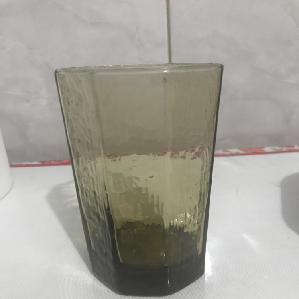

In [24]:
img = load_img(df_test.iloc[11]["filename"], target_size=(299, 299))
img

In [25]:
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)
prediction = classes[pred.argmax(axis=1)]
prediction

1/1 [==============================] - 0s 21ms/step


array(['glass'], dtype='<U5')

## Converting keras Model to TF-Lite

In [27]:
keras_model = keras.models.load_model("xception_v4_1_02_0.962.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

with open("image-classifier-model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpg7irpw15/assets


INFO:tensorflow:Assets written to: /tmp/tmpg7irpw15/assets
2022-12-12 07:58:14.870430: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-12 07:58:14.870483: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-12 07:58:14.870652: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpg7irpw15
2022-12-12 07:58:14.901621: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-12-12 07:58:14.901671: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /tmp/tmpg7irpw15
2022-12-12 07:58:15.020845: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-12-12 07:58:15.541025: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpg7irpw15
2022-12-12 07:58:15.755732: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

In [28]:
!pip install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime pillow

Looking in indexes: https://pypi.org/simple, https://google-coral.github.io/py-repo/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 92.6 MB/s eta 0:00:00


In [29]:
!pip install keras-image-helper

In [35]:
import tflite_runtime.interpreter as tflite
from keras_image_helper import create_preprocessor

interpreter = tflite.Interpreter(model_path="image-classifier-model.tflite")
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [37]:
preprocessor = create_preprocessor("xception", target_size=(299, 299))

url = "https://thumbs.dreamstime.com/b/glass-clean-drinking-water-44066082.jpg"
X = preprocessor.from_url(url)

interpreter.set_tensor(input_index, X)
interpreter.invoke()
pred = interpreter.get_tensor(output_index)
pred

array([[ 2.7233973, -1.0179147,  7.036037 , -3.4767456, -0.7703638,
        -1.6589949]], dtype=float32)

In [39]:
prediction = classes[pred.argmax(axis=1)]
prediction

array(['glass'], dtype='<U5')

In [42]:
image_path = df_test.iloc[13]["filename"]

In [43]:
X = preprocessor.from_path(image_path)

interpreter.set_tensor(input_index, X)
interpreter.invoke()
pred = interpreter.get_tensor(output_index)
prediction = classes[pred.argmax(axis=1)]
prediction

array(['plate'], dtype='<U5')

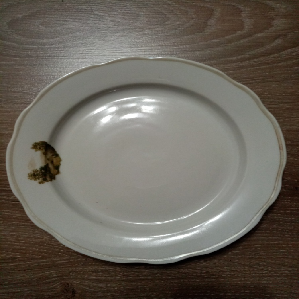

In [45]:
img = load_img(image_path, target_size=(299, 299))
img

In [46]:
prediction[0]

'plate'

## Tensorflow serving

In [48]:
# !pip install grpcio==1.42.0 tensorflow-serving-api==2.7.0

In [49]:
tf.saved_model.save(keras_model, "../image-classifier-model")

INFO:tensorflow:Assets written to: image-classifier-model/assets


INFO:tensorflow:Assets written to: image-classifier-model/assets


In [51]:
!tree ../image-classifier-model/

image-classifier-model/
├── assets
├── saved_model.pb
└── variables
    ├── variables.data-00000-of-00001
    └── variables.index

2 directories, 3 files


In [53]:
!saved_model_cli show --dir image-classifier-model --all

2022-12-12 08:42:17.614626: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 299, 299, 3)
        name: serving_default_input_2:0
  The given SavedModel SignatureDef contains the following output(s):
    

In [54]:
import grpc


from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc


In [55]:
host = 'localhost:8500'

channel = grpc.insecure_channel(host)

stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)


In [56]:
def np_to_protobuf(data):
    return tf.make_tensor_proto(data, shape=data.shape)

In [ ]:
pb_request = predict_pb2.PredictRequest()

pb_request.model_spec.name = 'image-classifier-model'
pb_request.model_spec.signature_name = 'serving_default'

pb_request.inputs['input_2'].CopyFrom(np_to_protobuf(X))

pb_response = stub.Predict(pb_request, timeout=20.0)
preds = pb_response.outputs['dense_1'].float_val
preds